In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import importlib
import numpy.ma as ma
import cartopy.crs as ccrs

In [2]:
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import matplotlib
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 

In [3]:
import plot_topView_contourf as topView
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

<IPython.core.display.Javascript object>


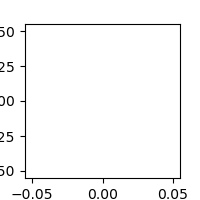

In [22]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

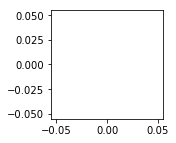

In [24]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [7]:
winds = []
with open("../../../Winds/list_files.txt") as file_list:
    for line in file_list:
        winds.append(xr.open_dataset("../../../Winds/ERA_interim/"+line.split("\n")[0]))

In [3]:
winds = xr.open_mfdataset("../../../Winds/ERA_interim/*.nc")

In [4]:
windsMergedSH = winds.sel(latitude=slice(-60, -89.25))

In [5]:
def compute_stress_curl(windsMergedSH):
    stress_curl = np.zeros_like(windsMergedSH.u10)
    wek = np.zeros_like(windsMergedSH.u10)
    rho0 = 1025
    tauy_x = np.zeros_like(windsMergedSH.u10)
    taux_y = np.zeros_like(windsMergedSH.u10)
    
    delta_lat = abs(float(windsMergedSH.latitude[0] - windsMergedSH.latitude[1]))
    delta_lon = abs(float(windsMergedSH.longitude[0] - windsMergedSH.longitude[1]))
    r = 6371e3 # radius of earth in metres
    dy = float(r * np.deg2rad(windsMergedSH.latitude[0] - windsMergedSH.latitude[1]))
    omega = 2*np.pi/(24.*3600)
    f = 2. * omega * np.sin(np.deg2rad(windsMergedSH.latitude.values))
    time_counter = 0
    for t in windsMergedSH.time:
    
        lat_counter = 0
        for lat in windsMergedSH.latitude:
            
            dx = float(r * np.cos(np.deg2rad(lat) ) * delta_lon)
        
            tauy_x[time_counter, lat_counter] = np.gradient(windsMergedSH.sel(time = t, latitude=lat).inss , dx)
            lat_counter+=1
        _, taux_y[time_counter] = np.gradient(windsMergedSH.sel(time = t).iews , dx, dy)
        stress_curl[time_counter] = tauy_x[time_counter] - taux_y[time_counter]
        
        for l in range(len(windsMergedSH.latitude)):
            wek[time_counter, l] = stress_curl[time_counter, l] / (f[l] * rho0)
        time_counter += 1
    
    
    windEk = xr.Dataset({'stressCurl':(['time', 'latitude', 'longitude'], stress_curl), 
                         'wek':(['time', 'latitude', 'longitude'], wek) }, 
                        coords={'time': windsMergedSH.time, 'latitude': windsMergedSH.latitude, 
                               'longitude': windsMergedSH.longitude})
    return windEk

In [7]:
windEk = compute_stress_curl(windsMergedSH)

In [30]:
windEk.to_netcdf("/media/data/Datasets/Winds/wek_ERA_interim_2004_2017.nc")

In [52]:
windEk

<xarray.Dataset>
Dimensions:     (latitude: 40, longitude: 480, time: 168)
Coordinates:
  * longitude   (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * time        (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2017-12-01
  * latitude    (latitude) float32 -60.0 -60.75 -61.5 ... -87.75 -88.5 -89.25
Data variables:
    stressCurl  (time, latitude, longitude) float32 ...
    wek         (time, latitude, longitude) float32 ...

In [6]:
windEk = xr.open_dataset("/media/data/Datasets/Winds/wek_ERA_interim_2004_2017.nc", chunks={'time':10})

In [7]:
import plot_bathymetryGradients as pbgrad
importlib.reload(pbgrad)

<module 'plot_bathymetryGradients' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_bathymetryGradients.py'>

In [8]:
bathy_gradient = pbgrad.compute_bathymetryGradients(lonstep=5, latstep=1)

In [9]:
bathy = xr.open_dataset('/media/data/Datasets/Bathymetry/GEBCO_2014_2D.nc')

In [10]:
lonlen = len(bathy.lon)
lonindices = np.arange(0, lonlen+1, 5) # lonstep=5, every 5th longitude
lonindices[-1] = lonindices[-1] - 1
bathyS = bathy.isel(lon=lonindices, lat=np.arange(0, 3600, 1))

In [11]:
bathy_gradient = ma.masked_array(np.array(bathy_gradient))
bathy_gradient.mask = (bathy_gradient < 0.002) | (bathyS.elevation < -3500) | (bathyS.elevation > -800)

In [12]:
bathyS['bathy_gradient'] = (['lat', 'lon'], bathy_gradient)

In [13]:
bathyS['bathy_gradient_mask'] = (['lat', 'lon'], bathy_gradient.mask)

In [14]:
region1LonLims = [ [-40.,-20.] ,  [60,70], [70,75], 
                  [75,82], [135,145], [170,180], [-180, -140]]

region1LatLims = [ [-74.8, -72], [-67., -66.], [-67, -66.],
                   [-67, -65.215], [-67, -64.], [-73.45, -70], [-77, -73]]

region2LonLims = [ [-20., 0.] ,  [29,37], [82,87], 
                  [101,112], [-120,-100], [-100,-60]]

region2LatLims = [ [-73.15, -69], [-69.44, -65.38], [-66., -65.], 
                   [-65.5, -64.5], [-73, -70.], [-71, -61.4]]

regionsLonlim = np.array(region1LonLims + region2LonLims)
regionsLatlim = region1LatLims + region2LatLims

In [15]:
regionsLonlim[regionsLonlim < 0] = regionsLonlim[regionsLonlim < 0] + 360

In [16]:
regionsLonlim[6][1] = 360

In [17]:
windlons = windsMergedSH.longitude.values
windlons[windlons > 180] = windlons[windlons > 180] - 360
windlats = windsMergedSH.latitude.values

In [18]:
regionSlopeMask = np.zeros(windsMergedSH.isel(time = 1).u10.shape, dtype=bool)
for i in range(len(regionsLatlim)):
    regionSlopeMask = regionSlopeMask + ~np.isnan(windsMergedSH.isel(time=1).u10.where\
                                        (windsMergedSH.longitude >= regionsLonlim[i][0]).where\
                                        (windsMergedSH.longitude <= regionsLonlim[i][1]).where\
                                        (windsMergedSH.latitude >= regionsLatlim[i][0]).where\
                                        (windsMergedSH.latitude <= regionsLatlim[i][1]).values)

In [19]:
bathyGradMask = bathyS.sel(lon= windlons, lat=windsMergedSH.latitude, method='nearest').bathy_gradient_mask.values

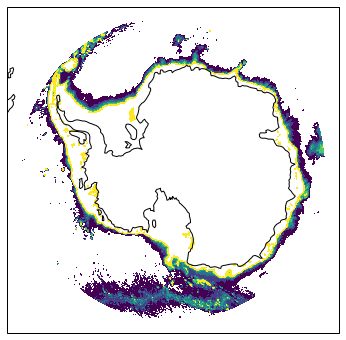

In [25]:
plt.close(1)
plt.figure(1, figsize=(6,6))
mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0) )

lons = bathyS.lon
lats = bathyS.lat
elev = bathyS.elevation.where(~bathyS.bathy_gradient_mask)

mapax.contourf(lons, lats, elev, vmin=-3000, vmax=-800, extend='both', transform= ccrs.PlateCarree())
mapax.coastlines()

plt.show()

In [68]:
monthlyMeanZonal

<xarray.DataArray 'u10' (month: 12, latitude: 40, longitude: 480)>
dask.array<shape=(12, 40, 480), dtype=float32, chunksize=(1, 40, 480)>
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 -60.0 -60.75 -61.5 ... -87.75 -88.5 -89.25
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

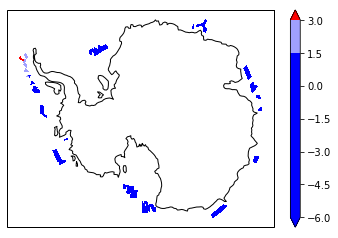

In [21]:
plt.close(1)
plt.figure(1)
mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0) )

lons = windsMergedSH.longitude.values
lats = windsMergedSH.latitude.values

monthlyMeanZonal = windsMergedSH.groupby(windsMergedSH.time.dt.month).mean(dim=['time']).u10.\
                                                       where(~bathyGradMask & regionSlopeMask).sel(month=3)

CF = mapax.contourf(lons, lats, monthlyMeanZonal, cmap='bwr', vmin=1, vmax=5, extend='both',
                     transform= ccrs.PlateCarree())
mapax.coastlines()

plt.colorbar(CF)
plt.show()

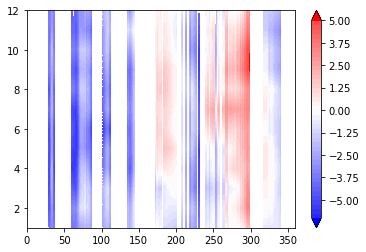

In [40]:
plt.close(1)
plt.figure(1)
ax = plt.subplot()

monthlyMeanZonal = windsMergedSH.groupby(windsMergedSH.time.dt.month).mean(dim=['time']).u10.\
                                                       where(~bathyGradMask & regionSlopeMask).mean(dim=['latitude'])
CF = ax.contourf(monthlyMeanZonal.longitude, monthlyMeanZonal.month, monthlyMeanZonal, 50, cmap='bwr', 
             vmin=-7, vmax=7, extend='both')
#lonticks = monthlyMeanZonal.longitude.values
#ax.set_xticks(lonticks[:])
#lonlabels = lonticks
#lonlabels[lonlabels > 180] = lonlabels[lonlabels > 180] - 360
#ax.set_xticklabels(np.array(lonlabels[:], dtype=str))
plt.colorbar(CF)
plt.show()

/home/km/anaconda3/envs/pyocean35/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


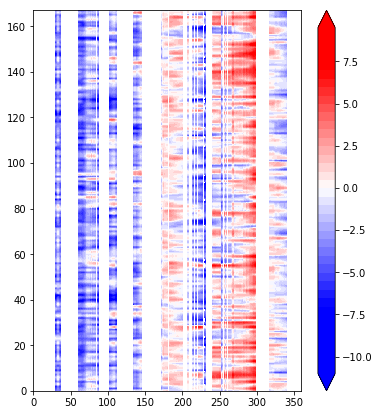

In [57]:
plt.close(1)
plt.figure(1, figsize=(6, 7))
ax = plt.subplot()
timeAxis = windsMergedSH.where(~bathyGradMask & regionSlopeMask ).u10.mean(dim=['latitude']).time
lonAxis = windsMergedSH.where(~bathyGradMask & regionSlopeMask).u10.mean(dim=['latitude']).longitude

zonalWind = windsMergedSH.where(~bathyGradMask & regionSlopeMask).u10.mean(dim=['latitude'])

CF = ax.contourf(lonAxis, np.arange(len(timeAxis)), zonalWind, 50, cmap='bwr', vmin=-7, vmax=7, extend='both')

plt.colorbar(CF)
plt.show()

In [ ]:
windEk.groupby(windEk.time.dt.month).mean(dim=['time']).wek.\
               where(~bathyGradMask & regionSlopeMask).mean(dim=['latitude']).plot(vmin=-1e-6, vmax=1e-6, extend='both', 
                                                                         cmap='bwr')

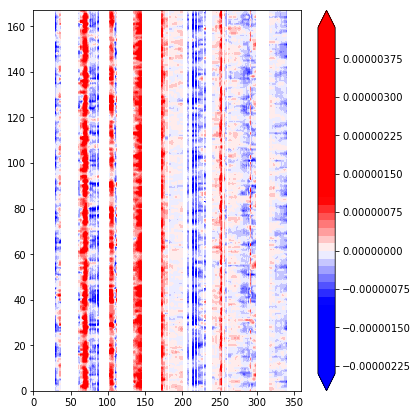

In [63]:
plt.close(1)
plt.figure(1, figsize=(6, 7))
ax = plt.subplot()

wek_LatMean = windEk.where(~bathyGradMask & regionSlopeMask).wek.mean(dim=['latitude'])

timeAxis = wek_LatMean.time
lonAxis = wek_LatMean.longitude

CF = ax.contourf(lonAxis, np.arange(len(timeAxis)), wek_LatMean, 50, cmap='bwr', vmin=-1e-6, vmax=1e-6, extend='both')

plt.colorbar(CF)
plt.show()

In [65]:
[[-80, -60]]*3

[[-80, -60], [-80, -60], [-80, -60]]

In [22]:
slopeLonLims = np.array([ [-40.,-25.] ,  [-5, 0], [0,8], 
                  [70, 88], [126,134], [148, 155],
                 [155, 170], [170, 180], [-120, -100],
                 [-90, -80], [-80, -75], [-75, -70]] + 
                        [[-25, -5], [8, 70], [88, 126], [134, 148], [-180, -120], [-100, -90], [-70, -40]])

slopeLatLims = [ [-80, -60], [-85, -67.6], [-85, -67.6],
                   [-67.5, -63.8], [-65, -60], [-66.7, -64.5],
                 [-80, -67], [-73, -70], [-73, -70],
                 [-70, -60], [-69, -60], [-68, -60] ] + [[-80, -60]]*4 + [[-80, -69]] + [[-80,-60]]*2

slopeLonLims[slopeLonLims < 0] = slopeLonLims[slopeLonLims < 0] + 360
slopeLonLims[1][1] = 360

In [23]:
slopeLonLims

array([[320., 335.],
       [355., 360.],
       [  0.,   8.],
       [ 70.,  88.],
       [126., 134.],
       [148., 155.],
       [155., 170.],
       [170., 180.],
       [240., 260.],
       [270., 280.],
       [280., 285.],
       [285., 290.],
       [335., 355.],
       [  8.,  70.],
       [ 88., 126.],
       [134., 148.],
       [180., 240.],
       [260., 270.],
       [290., 320.]])

In [24]:
slopeLatLims

[[-80, -60],
 [-85, -67.6],
 [-85, -67.6],
 [-67.5, -63.8],
 [-65, -60],
 [-66.7, -64.5],
 [-80, -67],
 [-73, -70],
 [-73, -70],
 [-70, -60],
 [-69, -60],
 [-68, -60],
 [-80, -60],
 [-80, -60],
 [-80, -60],
 [-80, -60],
 [-80, -69],
 [-80, -60],
 [-80, -60]]

In [25]:
slopeMask = np.zeros(windsMergedSH.isel(time = 1).u10.shape, dtype=bool)
for i in range(len(slopeLonLims)):
    slopeMask = slopeMask + ~np.isnan(windsMergedSH.isel(time=1).u10.where\
                                        (windsMergedSH.longitude >= slopeLonLims[i][0]).where\
                                        (windsMergedSH.longitude <= slopeLonLims[i][1]).where\
                                        (windsMergedSH.latitude >= slopeLatLims[i][0]).where\
                                        (windsMergedSH.latitude <= slopeLatLims[i][1]).values)

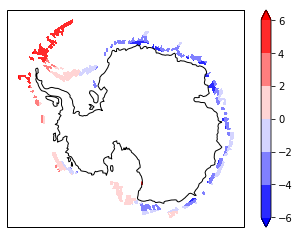

In [126]:
plt.close(1)
plt.figure(1)
mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0) )

lons = windsMergedSH.longitude.values
lats = windsMergedSH.latitude.values

monthlyMeanZonal = windsMergedSH.groupby(windsMergedSH.time.dt.month).mean(dim=['time']).u10.\
                                                       where(~bathyGradMask & slopeMask).sel(month=9)

CF = mapax.contourf(lons, lats, monthlyMeanZonal, cmap='bwr', extend='both',
                     transform= ccrs.PlateCarree())
mapax.coastlines()

plt.colorbar(CF)
plt.show()

/home/km/anaconda3/envs/pyocean35/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


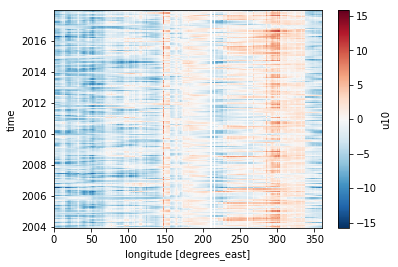

In [108]:
windsMergedSH.u10.where(~bathyGradMask & slopeMask).mean(dim=['latitude']).plot()

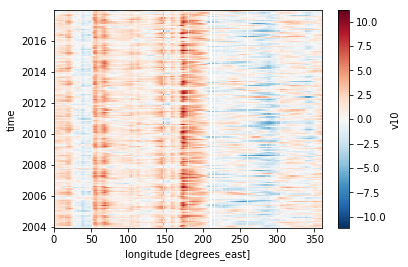

In [27]:
windsMergedSH.v10.where(~bathyGradMask & slopeMask).mean(dim=['latitude']).plot()

/home/km/anaconda3/envs/pyocean35/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


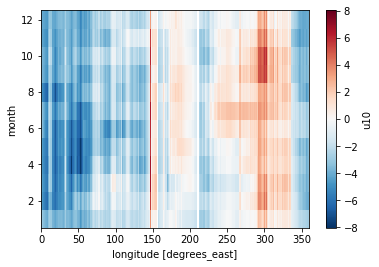

In [129]:
windsMergedSH.groupby(windsMergedSH.time.dt.month).mean(dim=['time']).\
u10.where(~bathyGradMask & slopeMask).mean(dim=['latitude']).plot()

/home/km/anaconda3/envs/pyocean35/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


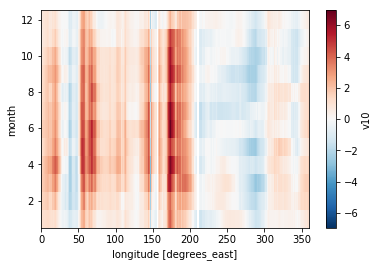

In [26]:
windsMergedSH.groupby(windsMergedSH.time.dt.month).mean(dim=['time']).\
v10.where(~bathyGradMask & slopeMask).mean(dim=['latitude']).plot()

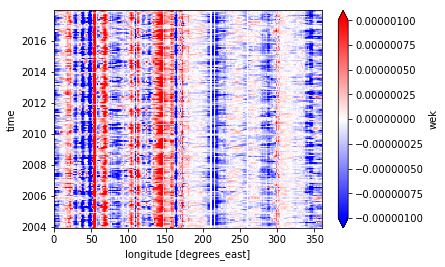

In [130]:
windEk.wek.where(~bathyGradMask & slopeMask).mean(dim=['latitude']).plot(vmin=-1e-6, vmax=1e-6, extend='both', 
                                                                         cmap='bwr')

/home/km/anaconda3/envs/pyocean35/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


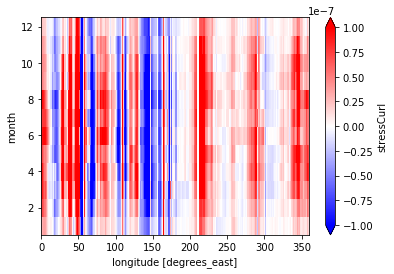

In [124]:
windEk.groupby(windEk.time.dt.month).mean(dim=['time']).stressCurl.where(~bathyGradMask & slopeMask)\
.mean(dim=['latitude']).plot(vmin=-1e-7, vmax=1e-7, extend='both', cmap='bwr')